### EE123 Lab 2: Software Defined Radio

### Written by Miki Lustig and Frank Ong

Before you start, you must make sure that the rtl-sdr drivers and its python support are installed. If you have not done so in the prelab, then  follow the instructions on the class website: 

https://inst.eecs.berkeley.edu/~ee123/sp16/rtl_sdr_install.html

In the first part of the lab, we will look at the power spectrum of the NOAA radio signal and introduce settings of the SDR along the way. In the second part of the lab, we will decode Mode-S ADS-B packets from the SDR, which allows us to track airplanes in realtime.



## About the SDR

The rtl-sdr usb dongles enables you to obtain samples from the electromagnetic spectrum around you. In very general terms, the dongle contains several components:

1. The antenna couples to received electromagnetic fields and tiny currents are produced in it. 
2. A tuner IC circuit amplifies the signal, filters it, demodulates it to an intermediate frequency where it is filtered again. The dongles we distributed in class contain either the Refael Micro 820T (Black dongles) tuner or the Elonics E4000  (white dongles). 
3. All dongles are equipped with the realtek RTL2832U (hence rtl-sdr). Although the chip is capable of doing many things (like decoding TV in Europe), we use only its analog to digital converters and its USB interface.  The RTL2832U samples the signal that is coming from the tuner and spits out samples to the computer through the USB interface. 

The SDR returns samples at a desired rate up to 2.4MS/s of a part of the spectrum around a desired center frequency. For example, setting a center frequency $f_0 = 88.5\cdot 10^6$ and a sampling rate of $Fs=2\cdot 10^6$ will result in a complex valued sequence $x[n]$ whos DTFT corresponds to the physical frequency range of $87.5\cdot 10^6 < f < 89.5\cdot 10^6$. In other words, the digital frequency $\omega=0$ of $X(e^{j\omega})$, the DTFT of $x[n]$, will correspond to the physical frequency $88.5$MHz. The digital frequency $\omega=\pi$ will correspond to $89.5$MHz and $\omega=-\pi$ will correspond to $87.5$MHz.

Q) How come the sequence $x[n]$ is complex valued ??? 

A) Consider the case when there is a transmitter which outputs a pure frequency at 89MHz. We choose a center frequency of 88.5MHz and sampling rate of 2MHz. The spectrum of $x[n]$ will not be symmetric, and has to be complex valued! The received signal would be $x[n] = e^{i2\pi500000/2000000n} = e^{i\pi/2n}$ which will have a single frequency at $\omega=\pi/2$ --> corresponding to 89MHz. 



To learn about what you can do with SDR's, I  recommend you watch this youtube video. Most (not all) the stuff shown there can be done using rtl-sdr. At minute 5:00 you will see an example of ADS-B, which you will partly implement in this lab.

In [1]:
# from IPython.display import YouTubeVideo
# # A video on what you can do with Software defined radio. The B200 is a high-end SDR which is capable to much more than the rtl-sdr. 
# # however, most of the stuff shown in the video could be done with the rtl-sdr as well. 
# YouTubeVideo('cygDXeZaiOM')

In [2]:
from rtlsdr import RtlSdr

In [3]:
# Import functions and libraries
from __future__ import division
import numpy as np, matplotlib.pyplot as plt, bokeh.plotting as bk
from numpy import *
from numpy.fft import *
from matplotlib.pyplot import *
from rtlsdr import RtlSdr
import threading,time
from bokeh.models import ColumnDataSource
bk.output_notebook()
# from IPython.html.widgets import interact

%matplotlib inline

Loading BokehJS ...

## Task I: Capture data and compute the spectrum
Let's look at a simple example of acquring data and looking at its spectrum. NOAA weather radio is transmitted from San Francisco at 162.4MHz It is a 5KHz frequency modeulated (FM) audio signal that voices a recording of the weather. If you live in the east-bay, you might also be able to pick up the Mt. Diablo transmitter at 162.425MHz. Here's a map of the SF coverage:

<img src="https://inst.eecs.berkeley.edu/~ee123/sp14/lab/KHB49.png" alt="Drawing" style="height: 500px;"/>

It's best if you are outside of the building when collecting samples. Let's collect 4 seconds worth of samples ,sampled with a center frequency of 162MHz and a sampling rate of 1MHz.

To Instantiate the sdr with the following parameters, which create the rtlsdr object, set the center frequency and the sampling rate

    sdr = RtlSdr()
    sdr.set_sample_rate(1000000)    # sampling rate
    sdr.set_center_freq(162e6)   # 162MhZ center frequency
    

In [5]:
# sdr.close()

In [6]:
# your code here:
fs = 1e6;
f0 = 162e6
sdr = RtlSdr()

Found Rafael Micro R820T tuner
[R82XX] PLL not locked!


In [7]:
sdr.set_sample_rate(1000000)    # sampling rate
sdr.set_center_freq(162e6)   # 162MhZ center frequency

Exact sample rate is: 1000000.026491 Hz


It is also useful to set the gain appropriately. The default is usually quite high and the signal saturates. 

To see what are the valid gains, invoke: 

    print(sdr.valid_gains_db)

The result will depend on the type of SDR you have (there are a few variants)

In [8]:
print(sdr.valid_gains_db)

[0.0, 0.9, 1.4, 2.7, 3.7, 7.7, 8.7, 12.5, 14.4, 15.7, 16.6, 19.7, 20.7, 22.9, 25.4, 28.0, 29.7, 32.8, 33.8, 36.4, 37.2, 38.6, 40.2, 42.1, 43.4, 43.9, 44.5, 48.0, 49.6]


Pick a number that's one or two slots larger than the middle and set the gain using
    sdr.set_gain(gain)
    

In [9]:
# your code here
gain = sdr.valid_gains_db[29//2 + 2]


The python interface to the SDR required that the number of samples be a multiple of 256. To read samples from the SDR, run the following command:

    N_samples = 1024000*4 # approximately seconds
    y = sdr.read_samples(N_samples)   # get samples

If you are done with the device, you can clear it by:
    sdr.close()

In [10]:
# your code here:


N_samples = 1024000*4 # approximately seconds
y = sdr.read_samples(N_samples)   # get samples


In case you are having trouble with the SDR, download 
https://inst.eecs.berkeley.edu/~ee123/sp16/lab/lab2/noaa.npy
, which is captured data we collected. 

In [11]:
# np.save('noaa.npy',y)

# # In case you are having trouble with the SDR, uncomment the line below to load Miki's capture
# y = np.load('noaa.npy')

We will only use a small portion of it to process and look at the spectrum. Let’s crop the samples and analyze the spectrum of a portion of 8000 samples of it. We will use the function `fft` to compute the DFT and then `fftshift` to center the DFT around $\omega=0$. Intead of showing the spectrum in terms of $\omega$, plot it in terms of the physical frequencies. Use a Kaiser window with $\beta=6$. Use the function `plt.semilogy` to plot in log-scale. Make sure the axis is tight using `plt.axis` and that the aspect ratio of the figure is wide, so you can see the spectrum better



In [12]:
samples = y[0:8000]

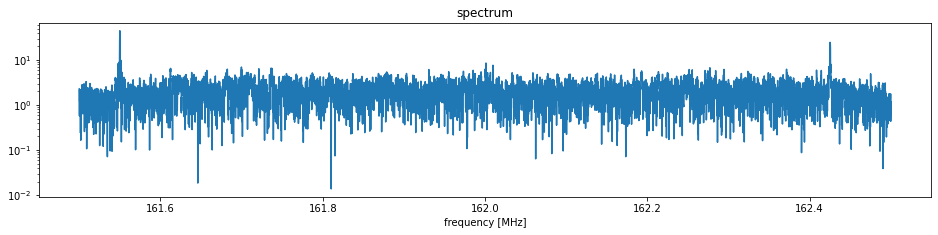

In [13]:
# your code here:
windowed_y = np.kaiser(len(samples), 6)*samples

Y_w = np.fft.fft( windowed_y )
Y_w = np.fft.fftshift(Y_w)
f = np.linspace(f0 - fs/2, f0 + fs/2, len(Y_w))

# Plot
width, height = figaspect(0.2)
fig=plt.figure(figsize=(width,height))
plt.semilogy( f/1e6, abs(Y_w)), plt.xlabel('frequency [MHz]'); 
plt.title('spectrum');

You should be able to see some energy in the spectrum around the right frequency. However, what you will notice immediately is that the spectrum is noisy. In addition there might be some spurious peaks and in the white dongles (E4000) there is also a large peak at the DC frequency. The peak at the DC frequency is due to constant bias in the ADC of the device. This translates to an impulse at $\omega = 0$. Spourius peaks come from local oscillator leak and also quantization erros. 

To reduce the noise and get a finer look at the spectrum, we will break our entire sequence to smaller sequences. We don't need such a good spectral resolution, so we will break it to chunks sized 800 samples, calculate their magnitude spectrum and average. This is also called average power specrum.

* Reshape the sequence into a matrix with row size of 800. Remember that the ordering of the matrix is 'C' style and hence row-first. 
* Multiply the rows by a kaiser window with $\beta=6$
* Compute fft and fftshift along the 2nd dimension. 
* Compute the absolute square of the result and average along the 1st dimension
* Plot the result

In [14]:
# your code here:

wkaiser = np.kaiser(800, 6)
yreshaped = np.reshape(samples, (10, 800))
for i in range(10):
    yreshaped[i] = yreshaped[i]*wkaiser
    
Y2_w = np.fft.fft(yreshaped, axis = 1)
Y2_w_shifted = np.fft.fftshift(Y2_w, axes = 1)
    
for i in range(10):
    Y2_w_shifted[i,:] = np.square(abs(Y2_w_shifted[i,:]))
    
Y2res = np.mean(Y2_w_shifted, 0)

/opt/anaconda3/envs/cse490/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


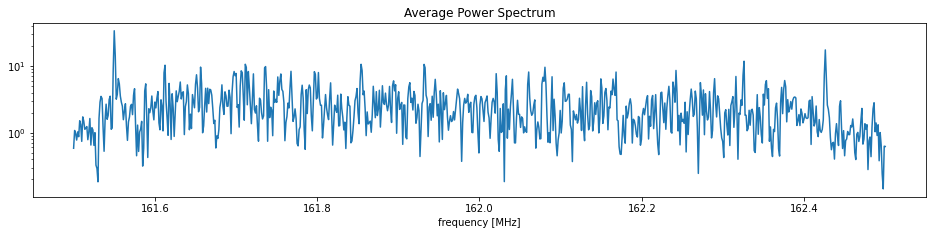

In [15]:
# your plotting code here
width, height = figaspect(0.2)
fig=plt.figure(figsize=(width,height))
f = np.linspace(f0 - fs/2, f0 + fs/2, len(Y2res))
plt.semilogy(f/1e6, Y2res), plt.xlabel('frequency [MHz]'); 
plt.xlabel('frequency [MHz]'); plt.title('Average Power Spectrum');

This plot is called average power spectrum. As you can see, the spectrum looks much nicer now. Can you identify the NOAA weather station? Only the wide spectrum peaks are real. BTW, The very narrow spiky peaks in the spectrum are probably not real signals. They are due to leakage of the local oscilator, non-linearity in the receiver, and poor dynamic range of the ADC of the device. Still... for 12$ it is not too bad!


* What is the spectral resolution in the plot?
* Repeat the the measurement and the average power spectrum for the center frequency 88.4MHz. Can you identify NPR 88.5 Station?

Note: The rectangular bands you see around the main signal are HD radio signals. These are transmitted at the band edges and provide digital radio programming. Unfortunately HD radio in the USA uses proprietery protocol, and we can not decode it at this time. 

Exact sample rate is: 1000000.026491 Hz


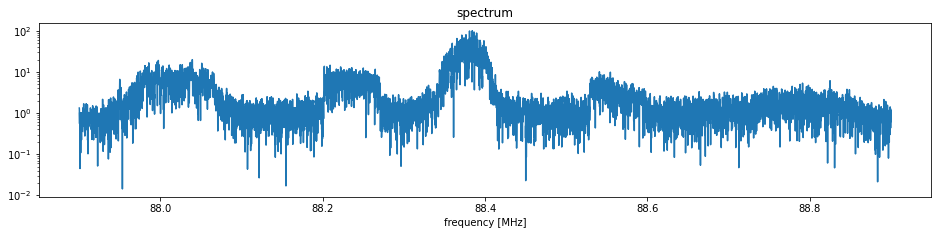

In [16]:
# your capture code here:

# sdr.close()

fs = 1e6;
f0 = 88.4e6
# sdr = RtlSdr()
sdr.set_sample_rate(1000000)    # sampling rate
sdr.set_center_freq(88.5e6)   # 162MhZ center frequency

gain = sdr.valid_gains_db[29//2 + 2]


N_samples = 1024000*4 # approximately seconds
y = sdr.read_samples(N_samples)   # get samples


samples = y[0:8000]

windowed_y = np.kaiser(len(samples), 6)*samples

Y_w = np.fft.fft( windowed_y )
Y_w = np.fft.fftshift(Y_w)
f = np.linspace(f0 - fs/2, f0 + fs/2, len(Y_w))

# Plot
width, height = figaspect(0.2)
fig=plt.figure(figsize=(width,height))
plt.semilogy( f/1e6, abs(Y_w)), plt.xlabel('frequency [MHz]'); 
plt.title('spectrum');

wkaiser = np.kaiser(800, 6)
yreshaped = np.reshape(samples, (10, 800))
for i in range(10):
    yreshaped[i] = yreshaped[i]*wkaiser
    
Y2_w = np.fft.fft(yreshaped, axis = 1)
Y2_w_shifted = np.fft.fftshift(Y2_w, axes = 1)
    
for i in range(10):
    Y2_w_shifted[i,:] = np.square(abs(Y2_w_shifted[i,:]))


In case you are having trouble with the SDR, download 
https://inst.eecs.berkeley.edu/~ee123/sp16/lab/lab2/npr.npy
, which is captured data we collected. 

In [17]:
#np.save('npr.npy',y)

#In case you are having trouble with the SDR, uncomment the line below to load Miki's capture
#y = np.load('npr.npy')

/opt/anaconda3/envs/cse490/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


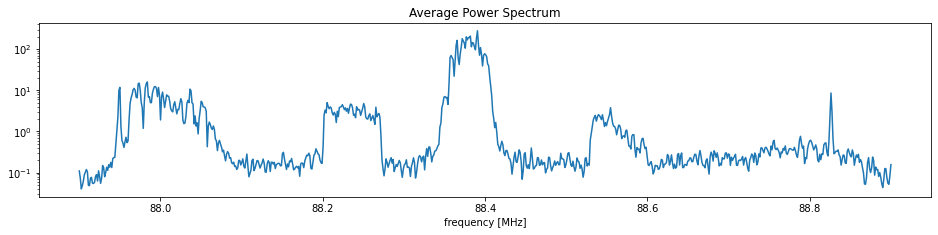

In [18]:
# your beautiful plot code here:
Y2res = np.mean(Y2_w_shifted, 0)
width, height = figaspect(0.2)
fig=plt.figure(figsize=(width,height))
f = np.linspace(f0 - fs/2, f0 + fs/2, len(Y2res))
plt.semilogy(f/1e6, Y2res), plt.xlabel('frequency [MHz]'); 
plt.xlabel('frequency [MHz]'); plt.title('Average Power Spectrum');

## Task II: Capturing, detecting and extracting Mode S ADS-B Packets with RTL-SDR

The following text is adapted from (https://github.com/bistromath/gr-air-modes).

__Mode S__ is the transponder protocol used in modern commercial aircraft.
A Mode S-equipped aircraft replies to radar interrogation by either
ground radar (secondary surveillance) or other aircraft ("Traffic
Collision Avoidance System", or TCAS).

__Automatic Dependent Surveillance-Broadcast (ADS-B)__ is a communication
protocol using the Extended Squitter capability of the Mode S transport
layer.  The protocol is:

* Automatic: it requires no pilot input
* Dependent: it is dependent on altimeter, GPS, and other aircraft
  instrumentation for information
* Surveillance: it provides current information about the transmitting
  aircraft
* Broadcast: it is one-way, broadcast to all receivers within range.

ADS-B-equipped aircraft broadcast ("squitter") their position, velocity,
flight number, and other interesting information to any receiver within
range of the aircraft. Position reports are typically generated once per
second and flight indentification every five seconds.

Packets are sent at 1090Mhz and use Pulse Position Modulation (PPM) at a rate of 1Mbit per second. The simple modulation scheme is designed to be trancieved by cheap hardware -- which is very much what we are doing in this lab!

Pulse position modulation belongs to the family of amplitude modulated signals and in particular to the type of amplitude-shift-keying (ASK) or on-off-keying (OOK). In OOK, `0`, `1` bits are sent by turning the carrier on and off. PPM uses [Manchester](http://en.wikipedia.org/wiki/Manchester_code) encoding variant of OOK. The idea in Machester encoding is that in each bit interval there is always a transition between on and off and the transition occurs in the middle of the bit interval. For example, a transition from off to on would represent a `0` and a transition from on to off would represent a `1`. Manchester codes have the advantage of being self clocking so the clock can be recovered from the data stream. 

A mode S ADS-B packet consists of an $8\mu$s preamble followed by a data block of 56 or 112 $\mu$s data block. A preamble is a signal used in network communications to synchronize transmission timing between two or more systems. Here's a diagram that illustrates a typical packet:


<img src="https://inst.eecs.berkeley.edu/~ee123/sp14/lab/adsb-packet.png" alt="Drawing" style="height: 200px;"/>

Now, since the bit-rate is 1Mbit per second, then a sampling rate of 2Msample/sec should be sufficient to capture the bit transitions, detect the preamble and deode packets. In practice, ADS-B packets can be decoded using the rtl-sdr, but the captured data does not look like the ideal packet. Here's an example of a part of a captured packet:

<img src="https://inst.eecs.berkeley.edu/~ee123/sp14/lab/real_adsb_packet.png" alt="Drawing" style="height: 200px;"/>

( This packet is rescaled to have a maximum amplitude of 128. Your packet does not neccessarily have this height, in fact, the maximum value of packets you will receive will be between 0.0 and 1.0)


As you can see, there are many distortions: the key-off is not zero and there are variations in the amplitudes of the key-on. These come from various sources including the anti-aliasing filters, interfering signals, noise, gain control and more. However, it is possible to clearly see the preamble and the packet bit content! This is pretty amazing that this can be done using a 12$ usb dongle because ADS-B equipment is very expensive.

There are several types and subtypes of "Squitters":

* Short squitters are 56bits (8bits Control,  24bits address, 24bits parity check)
* Long squitters are 112bits (8bits control, 24bits address, 56bits ADS message, 24bits parity)

Only the long squitters have location information in them. 

### Acquire samples  
When acquiring data, it is highly recommneded that you be OUTSIDE or close to a BIG window. Electromagnetic radiation at 1090MHz does not penetrate through walls. In addition, the antenna you got with the dongle is not ideal for ADS-B reception. It is also recommended that you do this part during the day and not at night, when the air-traffic in the bay area is low. 

_Remember that the absolute gain of the signal is not important. It is the relative gain between your signal and noise that affects the detection, so a higher SDR gain does not mean a better signal-to-noise ratio (SNR)._

* Set the rtl-sdr to a center frequency of 1090MHz, sampling rate of 2MS/s and a gain slightly higher than the middle in the list of possible gains. You can play with the gain later if the results are not satisfactory. 
* Acquire 2,048,000 samples (approx 1 sec) and take their magnitude. We will only work with magnitude data. 
* Plot the magnitude of the received signal. Do you see any strong bursts in the amplitude? If you don't, repeat this task untill you do. This will make sure you have data to work with.

Here's an example of a good signal:

<img src="https://inst.eecs.berkeley.edu/~ee123/sp16/lab/lab2/packets.png" alt="Drawing" style="height: 200px;"/>

Note that not all packets are ADS-B ones. ADS-B will have the right preamble. 

Found Rafael Micro R820T tuner
[R82XX] PLL not locked!
Exact sample rate is: 2000000.052982 Hz


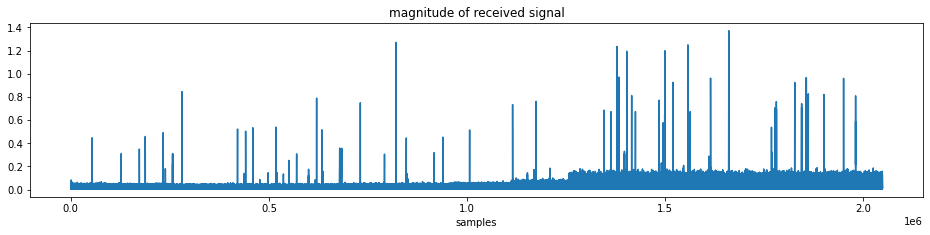

In [19]:
# your acquisition code

sdr.close()

fs = 1e6;
f0 = 88.4e6
sdr = RtlSdr()
sdr.set_sample_rate(2000000)    # sampling rate
sdr.set_center_freq(1090e6)   # 162MhZ center frequency

gain = sdr.valid_gains_db[len(sdr.valid_gains_db)//2 + 2]


N_samples = 2048000 # approximately 2 seconds
y = sdr.read_samples(N_samples)   # get samples


samples = y[0:8000]

# windowed_y = np.kaiser(len(samples), 6)*samples

# Y_w = np.fft.fft( windowed_y )
# Y_w = np.fft.fftshift(Y_w)
# f = np.linspace(f0 - fs/2, f0 + fs/2, len(Y_w))

# # Plot
# width, height = figaspect(0.2)
# fig=plt.figure(figsize=(width,height))
# plt.semilogy( f/1e6, abs(Y_w)), plt.xlabel('frequency [MHz]'); 
# plt.title('spectrum');




# Plotting code
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plot( abs(y ))
title('magnitude of received signal')
xlabel('samples')

sdr.close()

* Save the magnitude of the data to a file. This will help you in the programming and debugging portions, so you don't have to reacquire date and rely on airplanes to be present all the time. Use the feature `np.save('adsb.npy',y)` to save the array. Use `np.load` to load it back. You can also use the data we provided for you (through the lab link) for debugging, but please submit plots from your OWN data. 

In case you are having trouble with the SDR, download 
https://inst.eecs.berkeley.edu/~ee123/sp16/lab/lab2/adsb.npy
, which is captured data we collected. 

In [20]:
np.save('adsb.npy',abs(y))

In [21]:
# data loading code 

y = np.load('adsb.npy')
fs = 2000000;
y = abs(y) / max(abs(y))

Before we start at automatically detecting packet, let's look at one. We have written a bokeh plot below (run the following two cells) to help you scroll through the signal. 
*Make sure you run the interact cell to get access to the slider. 

* Manually look for a packet in the received signal. Look for ones with high amplitude. You can use `nonzero(y == max(abs( y)))[0]` to find the index of the maximum signal. 
* Display the packet from `idx` to `idx + 16 + 112 * 2`, where `idx` is the start index of the packet

In [22]:

fig = bk.figure( plot_width = 800, plot_height = 300, 
                x_axis_label = "Index - plot_start",
                y_axis_label = "Amplitude",
                tools = ("xpan", "xwheel_zoom","reset"), 
                y_range=[0,1])

ymax = max(abs(y))
plot_length = 1000
idxs = r_[:plot_length]
y_chunk = abs(y[:plot_length]) / ymax

seg_source = ColumnDataSource(data=dict(x0=idxs,y0=y_chunk*0,x1=idxs, y1=y_chunk ))
cir_source = ColumnDataSource(data=dict(x=idxs, y=y_chunk))

fig.circle( idxs, y_chunk, source = cir_source )
fig.segment( idxs, y_chunk * 0, idxs, y_chunk, source = seg_source )
bk.show(fig)


def plot_update ( plot_start = 0 ):
    y_chunk = abs(y[plot_start:min(plot_start+plot_length,len(y))]) / ymax
    seg_source.data['y0'] = y_chunk * 0
    seg_source.data['y1'] = y_chunk
    cir_source.data['y'] = y_chunk
    cir_source.push_notebook()
    seg_source.push_notebook()    


RuntimeError: 

Expected x and y to reference fields in the supplied data source.

When a 'source' argument is passed to a glyph method, values that are sequences
(like lists or arrays) must come from references to data columns in the source.

For instance, as an example:

    source = ColumnDataSource(data=dict(x=a_list, y=an_array))

    p.circle(x='x', y='y', source=source, ...) # pass column names and a source

Alternatively, *all* data sequences may be provided as literals as long as a
source is *not* provided:

    p.circle(x=a_list, y=an_array, ...)  # pass actual sequences and no source



In [23]:
# Slider to scroll through signal Use the arrows rather than dragging for better accuracy

i = interact( plot_update, plot_start = (0, len(y)-plot_length, plot_length))

NameError: name 'interact' is not defined

<StemContainer object of 3 artists>

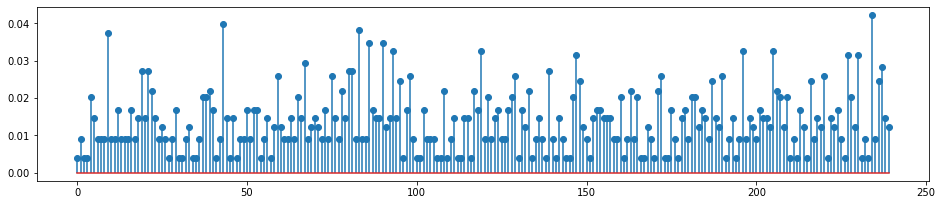

In [24]:
# Display the chunk, please change the code below for your capture. 
# The one below is for Miki's capture


idx = 590
chunk_length = 112 * 2 + 16

y_chunk = y[idx: idx + chunk_length] 

width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.stem( abs(y_chunk ) )

Answer the following questions:

* Is this a long or short squitter?
* Decode the bits of the packet. Remember, here the Manchester coding maps high-to-low to '1' and low-to-high to '0'. Provide the values with your answer. 

<StemContainer object of 3 artists>

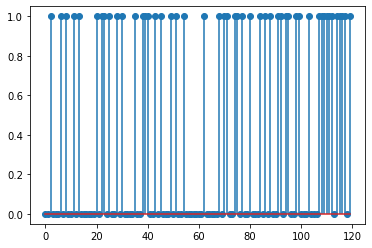

In [25]:
# code to decode the packet bits -- should be one liner.

decoded = np.array([1 if y_chunk[2*i+1]<y_chunk[2*i] else 0 for i in range(len(y_chunk)//2)])

# plot the bits
plt.stem(decoded)

Text answer: long squitter: 112 bits.







### Preamble Detection

We would like to automatically detect packets. Detecting the preamble is a good way to start, as the preamble is the same for all packets. In general, a good detector should have the minimum number of false negatives and false positives. For ADS-B packets, we care more about false negatives, since this means that we may be missing an important packet. At the same time, a false positive would result in a packet which we can not decode, which is not harmful, except that we spend time in extra computation to perform parity checks. 

#### Noise floor estimation
When looking at detection, it is useful to know what is the noise level compared to the signal level. This can help setting thresholds for detecting signals. When noise has Gaussian statistics, we can calculate the sample mean and sample standard deviation to estimate its distribution. Unfortunately, our received signal is not only contaminated by Gaussian random noise. It is also contaminated by interference as well as bursts of ADS-B packet data. If we compute the sample mean and standard deviation, they could be biased by strong outliers coming from the packet bursts. 

Here's where the median can come to our rescue. The median is a measure, which is robust to outliers and can be used to estimate the mean. In order to robustly estimate the standard deviation we can use the Median Absolute Deviation (MAD) estimator: http://en.wikipedia.org/wiki/Median_absolute_deviation. The MAD is computed in the following way:

$$ \mathrm{MAD}(X) = \mathrm{median}(|X - \mathrm{median}(X)|) $$

As it turns out, the standard deviation can be approximated from the MAD by:

$$\sigma \approx 1.4826 \mathrm{MAD} $$


* Compute the median 
* Compute the MAD and estimate the standard deviation.


In [26]:
# your code here
y_median = np.median(y)
y_mad = np.median(abs(y - y_median))
y_std = 1.4826*y_mad

print(y_median)
print(y_mad)
print(y_std)

0.014589723094565401
0.005642582564002531
0.008365692909390151


#### Signal Amplitude Detector 
Optimal thresholds based on noise are beyond the scope of this lab. However, we need to come up with a threshold for which we can say that a received signal (ANY signal, not just ADS-B) is above it. 
A safe bet would be the mean plus some multiples of the standard deviation. A factor of 3 to 5 is reasonable.  


* set the threshold to be `thresh = y_median + N*y_std`, when N is 3 to 5. (Experiment!)
* find all the indexes for which the received signal is greater than the threshold. Call the list `idx_sig`. We will use these indexes later to detect preambles (Hint: use `nonzero(input)[0]`)

Once you estimated the threshold, you can reuse it for subsequenct captures, and do not need to recalculate it. You can refresh the estimates periodically as things may change over time. 

In [28]:
import scipy.stats

In [30]:
# your code here:
N=5
threshfn = lambda N: y_median + N*y_std

def threshold(a, threshmin=None, threshmax=None, newval=0):
    a = ma.array(a, copy=True)
    mask = np.zeros(a.shape, dtype=bool)
    if threshmin is not None:
        mask |= (a < threshmin).filled(False)

    if threshmax is not None:
        mask |= (a > threshmax).filled(False)

    a[mask] = newval
    return a

print(threshfn(2), threshfn(3), threshfn(4), threshfn(5), threshfn(6))

thresh = threshfn(N)

y_thresh = threshold(y, threshmin = thresh, newval = 0)
idx_sig = np.nonzero(y_thresh)[0]

0.031321108913345705 0.03968680182273585 0.04805249473212601 0.05641818764151616 0.06478388055090631


In [31]:
idx_sig.shape

(85306,)

#### Normalized Cross Correlation Detection
Detecting that a signal is received does not mean that it is the right signal! We would like to make sure it is the preamble. There are many ways we can go about detecting the preamble. We already saw in Lab 1 that matched filtering can be used for detection.  Take a look at the ideal preamble below, and  a preamble we (Frank and I) measured when preparing the lab.


<img src="https://inst.eecs.berkeley.edu/~ee123/sp14/lab/real_adsb_packet.png" alt="Drawing" style="height: 200px;"/>




We saw that matched filtering is implemented using cross correlation. Here, we will also use cross correlation. However, we need to remember to subtract the mean from each of the signals! (We didn't do it for the chirp, since the chirp has zero mean). The cross correlation is defined as:
$$ R_{xy}[n] = \sum_{k=0}^{15} (x[n+k]- \hat{x}_n) (y[k] - \hat{y} )$$
, where $\hat{x}_n$ is the mean of $x$ in a window size 16 around the index $n$.

The issue is that the result would depend on the signal's magnitude. It will be hard to give a "score" of detected or not. Therefore we will use a normalized cross correlation instead, which is defined as 
$$ \hat R_{xy}[n] = \frac{\sum_{k=0}^{15} (x[n+k]- \hat{x}_n) (y[k] - \hat{y} )}{||x[n]-\hat{x}_n||\cdot ||y-\hat y||}$$
This will guarentee that the result is bounded between -1 and 1. 

To make the implementation fast and easy, we will first write a function that calculates the normalized cross correlation of a 16 sample window of the signal. We will then, loop through only the indexes of the signal for which the signal amplitude detection was above the threshold.  Using for loops is not an efficient implementation in Python, but it will do for this purpose. You are more than welcome to write your own efficient implementation. 

* Write a function `detectPreambleXcorr(chunck,corrthresh)`. The function accepets an array of 16 samples, e.g., $x[n]\cdots x[n+15]$. It evaluates the normalized cross correlation with an ideal preamble, and returns a True if it is greater than `corrthresh`

In [32]:
def detectPreambleXcorr(chunk, corrthresh):
    # The function accepets an array of 16 samples, e.g., x[n]⋯x[n+15]. 
    # It evaluates the normalized cross correlation with an ideal preamble, 
    # and returns a True if it is greater than corrthresh
    cmean = np.mean(chunk)
    preamble = array([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]) # - .25
    pmean = np.mean(preamble)
    
    pdenom = np.sqrt(abs((preamble - pmean).dot(preamble - pmean)))
    cdenom = np.sqrt(abs((chunk - cmean).dot(chunk - cmean)))
    
    xcorr = 0
    for n in range(len(chunk)):
        xcorr += (chunk[n] - cmean)*(preamble[n] - pmean)/(cdenom*pdenom)
        
    return (xcorr > corrthresh)

* Loop over the inputs for which the signal amplitude was above the amplitude threshold to detect packets. Set a correlation threshold of 0.85. Store all the positions of detected packet in an array `idx_corr`. If you did not detect any packets, reduce the threshold. (Warning: This operation may take more than a minute on some laptops for a low signal threshold)




In [33]:
# your code here:
idx_corr = []
for i in idx_sig:
    idx_corr += [detectPreambleXcorr(y[i:i+16],.85)]

In [34]:
idx_corr = np.array(idx_corr)

* Create a matrix `msgs`, in which each row contains a detected packet. Make each row `(16 + 112*2)` long to accomodate the long squitters. 
* Display the matrix as an image. You should be able to see four vertical lines on the left corresponding to the preamble. Do you see short and long squitters?

Text(0.5, 0, 'The Received message')

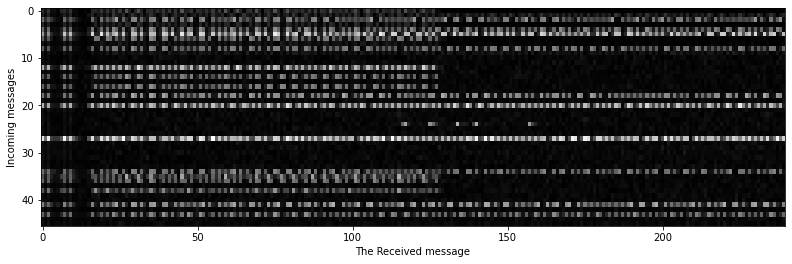

In [35]:
# your code here:
msgs = []
for i in range(len(idx_sig)):
    if(idx_corr[i]):
        idx = idx_sig[i]
        msgs += [y[idx:idx+(16+112*2)]]

# display code:
width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
plt.imshow(msgs, aspect='auto', cmap="gray")
plt.ylabel("Incoming messages")
plt.xlabel("The Received message")

#### Preamble Detection Using Logic

Unfortunately, our received preambles have varying total amplitudes (planes are near and far), have bias, and also exhibit amplitude modulation. At the same time, the preamble is relatively short. Instead of matched filtering, we can devise a non-linear descriptor which may be more robust. Here, we will look at detecting the preamble using logic.


<img src="https://inst.eecs.berkeley.edu/~ee123/sp14/lab/real_adsb_packet.png" alt="Drawing" style="height: 200px;"/>



Considering again the ideal preamble.  Notice, that there are four values which are high `[0, 2, 7, 9]`and there are 12 values which are low `[1,3,4,5,6,8,10,11,12,13,14,15]`. If we just consider logic, e.g., comparing high's and low's , we can make our detection significantly more robust to the bias and amplitude modulation.  Another benefit of using logic is that it can be computationally more efficient than normalized matched filtering. Because of this, it is more suitable for real-time applications.

Of course, it is possible to introduce more conditions. For example, in order to avoid detection of noise signal that resembles the logic, we can set a minimum limit on the amplitude of high's we consider a detection. In addition, to be able to separate between high's and low's we need to have a good amplitude margin -- so we can set a threshold for a minimum average margin between them.


* Implement a function `idx_preamble = detectPreamble( y )`. The function will accept the entire signal and will return a list of indices containing the start of each preamble. The basic logic of the function should be based on comparing high's and low's bits. (Hint: use `nonzero` to find the indices that satisfy the conditions). If you want to add thresholds using the MAD as well, you are more than welcome! 
* Try to make your function as efficient as possible, since it will be used in real-time in the next part
* Run the function on the signal `y`

In [38]:
def detectPreamble(y):
    # Function accepts sdr samples and returns a list of indices containing the 
    #start of each preamble.
    
    # your code here:
    idx_preamble = []
    #estimate noise floor
    N=5
    y_median = np.median(y)
    y_mad = np.median(abs(y - y_median))
    y_std = 1.4826*y_mad
    threshfn = lambda N: y_median + N*y_std
    thresh = threshfn(N)
    y_thresh = threshold(y, threshmin = thresh, newval = 0)
    
    idx_sig = np.nonzero(y_thresh)[0]
    y = y_thresh
    #estimate highs, lows.
    for i in idx_sig:
        if i + 16 >= len(y):
            break
        
        chunk = y[i:i+16]
        cmean = np.mean(chunk)
        if (chunk[0]>cmean and chunk[2]>cmean and chunk[7]>cmean and chunk[1]<=cmean and chunk[9]>cmean 
            and chunk[3]<=cmean  and chunk[4]<=cmean  and (chunk[5]<=cmean or chunk[6]<=cmean) and (chunk[8]<=cmean or chunk[6]<=cmean)
            and (chunk[14]<=cmean and chunk[13]<=cmean)):
            idx_preamble += [i]

    return np.array(idx_preamble)

In [39]:
idx_preamble = detectPreamble(y)

In [40]:
idx_preamble.shape

(98,)

* Create a matrix, in which each row contains a detected packet. Make each row `16 + 112*2` long to accomodate the long squitters. 
* Display the matrix as an image. You should be able to see four vertical lines on the left corresponding to the preamble. Do you see short and long squitters?

Text(0.5, 0, 'The Received message')

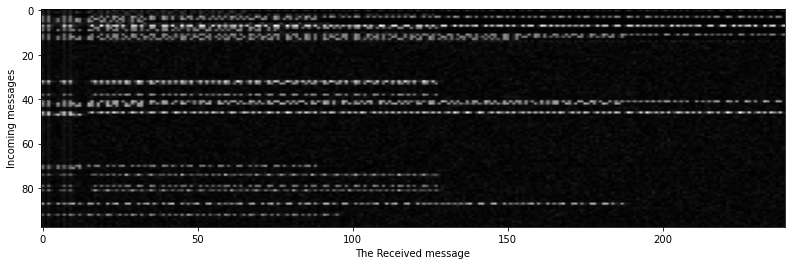

In [41]:
# your code here:
msgs = []
for idx in idx_preamble:
    msgs += [y[idx:idx+(16+112*2)]]


width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
plt.imshow(msgs, aspect='auto', cmap="gray")
plt.ylabel("Incoming messages")
plt.xlabel("The Received message")

Now that you can detect the preambles, the only task left is to decode the messages. Decoding the packets is beyond the scope of this lab. But in the next part of the lab, we have provided an ADS-B decoder so that you can extract flight positions.


## You are now ready to proceed to the real-time flight radar lab